In [1]:
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt

from bayesian_analysis import FitConfig
from cr_knee_fit import experiments
from cr_knee_fit.experiments import Experiment
from cr_knee_fit.fit_data import CRSpectrumData, GenericExperimentData
from cr_knee_fit.model import Model, ModelConfig
from cr_knee_fit.plotting import plot_credible_band, plot_posterior_contours
from cr_knee_fit.types_ import Primary

In [2]:
FIT_DIR = Path("out/composition")
fc = FitConfig.model_validate_json((FIT_DIR / "config.json").read_text())
theta_sample = np.loadtxt(FIT_DIR / "theta.txt")
median_model = Model.unpack(np.median(theta_sample, axis=0), layout_info=fc.model)

# p / He ratio


In [3]:
R_BOUNDS = (7e2, 1e6)

In [4]:
nucleon = Experiment("NUCLEON")
# exps = [experiments.ams02, experiments.calet, nucleon]
exps = [experiments.ams02, experiments.calet]
p_He_ratio_data: list[GenericExperimentData] = []
for exp in exps:
    path = f"data/output/{exp.filename_prefix}_p_He_ratio_rigidity.txt"

    cols = (0, 1, 2, 3, 4, 5)
    R, value, err_sta_lo, err_sta_up, err_sys_lo, err_sys_up = np.loadtxt(
        path, usecols=cols, unpack=True
    )
    mask = np.logical_and(R >= R_BOUNDS[0], R <= R_BOUNDS[1])
    p_He_ratio_data.append(
        GenericExperimentData(
            x=R[mask],
            y=value[mask],
            y_errhi=np.sqrt(err_sta_up[mask] ** 2 + err_sys_up[mask] ** 2),
            y_errlo=np.sqrt(err_sta_lo[mask] ** 2 + err_sys_lo[mask] ** 2),
            experiment=exp,
            label="H/He",
        )
    )

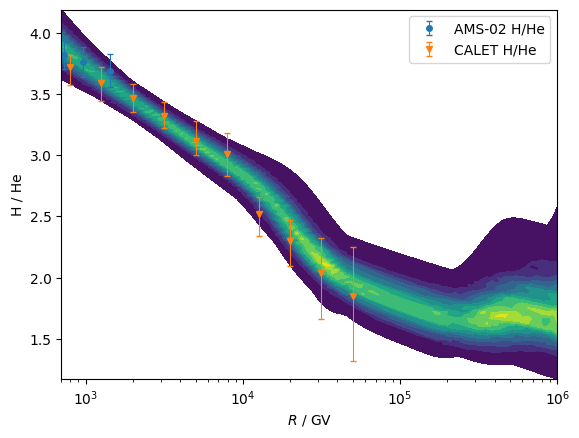

In [12]:
from cr_knee_fit.plotting import plot_ghostly_lines


fig, ax = plt.subplots()


def H_He_ratio(model: Model, R: np.ndarray) -> np.ndarray:
    return model.cr_model.compute_rigidity(R, Primary.H) / model.cr_model.compute_rigidity(
        R, Primary.He
    )


def H_He_ratio_shifted_to_calet(model: Model, R: np.ndarray) -> np.ndarray:
    f_CALET = model.energy_shifts.f(experiments.calet)

    dNdR_per_primary = []
    for p in (Primary.H, Primary.He):
        E = R * p.Z
        dNdE = model.cr_model.compute(E / f_CALET, primary=p) * f_CALET
        dNdR_per_primary.append(dNdE * p.Z)

    return dNdR_per_primary[0] / dNdR_per_primary[1]


for d in p_He_ratio_data:
    d.plot(ax=ax)

for observable, label, color in (
    (H_He_ratio, "Composition fit", "red"),
    # (H_He_ratio_shifted_to_calet, "Composition fit shifted to CALET energy", "green"),
):
    plot_posterior_contours(
        ax,
        scale=0,
        bounds=R_BOUNDS,
        observable=observable,
        theta_sample=theta_sample,
        model_config=fc.model,
    )

    # plot_ghostly_lines(
    #     ax,
    #     scale=0,
    #     bounds=R_BOUNDS,
    #     observable=observable,
    #     theta_sample=theta_sample,
    #     model_config=fc.model,
    #     n_samples=300,
    #     color="red",
    # )
    # plot_credible_band(
    #     ax,
    #     scale=0,
    #     bounds=R_BOUNDS,
    #     observable=observable,
    #     theta_sample=theta_sample,
    #     model_config=fc.model,
    #     color="red"
    # )

ax.set_xlabel("$ R $ / $ \\text{GV} $")
ax.set_xscale("log")
ax.set_ylabel("H / He")
# ax.set_yscale("log")
ax.legend()
plt.show()

# p + He (light group)


In [6]:
from cr_knee_fit import experiments
from model.utils import load_data


exps = [experiments.cream, experiments.dampe, Experiment("TIBET")]
light_group_data: list[CRSpectrumData] = []
for exp in exps:
    raw = load_data(
        filename=f"{exp.filename_prefix}_light_energy.txt",
        slope=0,
        norm=1.0,
        min_energy=1e3,
        max_energy=1e6,
    )
    light_group_data.append(
        CRSpectrumData(
            E=raw[0],
            F=raw[1],
            F_errlo=raw[2],
            F_errhi=raw[3],
            experiment=exp,
            primary=(Primary.H, Primary.He),
        )
    )

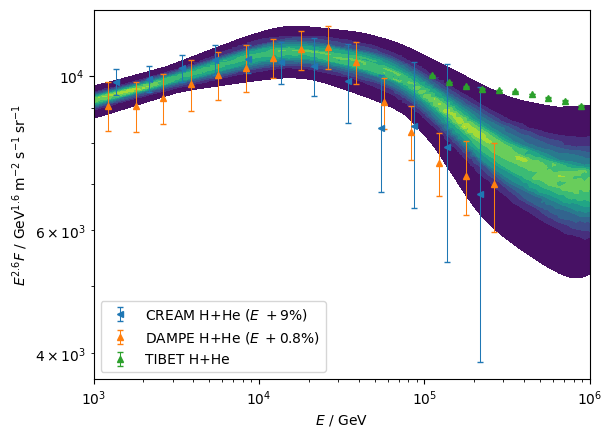

In [7]:
from cr_knee_fit.utils import label_energy_flux


fig, ax = plt.subplots()
scale = 2.6

for d in light_group_data:
    f = median_model.energy_shifts.f(d.experiment)
    d.with_shifted_energy_scale(f).plot(scale=scale, ax=ax)

plot_posterior_contours(
    ax,
    scale=scale,
    bounds=(1e3, 1e6),
    observable=lambda model, E: (
        model.cr_model.compute(E, primary=Primary.H) + model.cr_model.compute(E, primary=Primary.He)
    ),
    theta_sample=theta_sample,
    model_config=fc.model,
)
label_energy_flux(ax, scale=scale)
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

# All-particle

Text(0.5, 1.0, 'All particle')

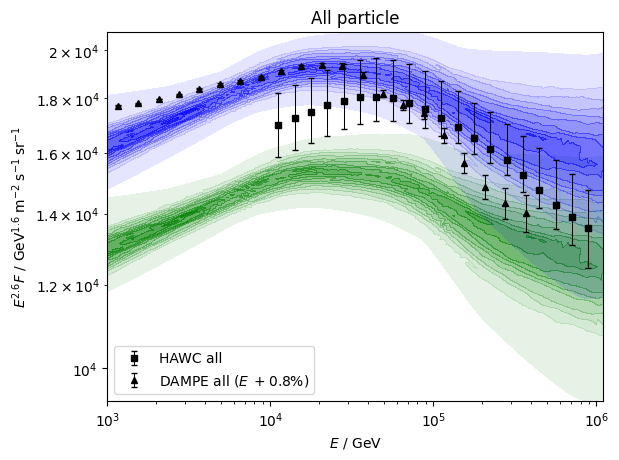

In [8]:
from matplotlib import colors

from cr_knee_fit.plotting import tricontourf_kwargs_transparent_colors


fig, ax = plt.subplots()
scale = 2.6

for exp, max_energy in ((experiments.hawc, None), (experiments.dampe, 6e5)):
    d = CRSpectrumData.load_all_particle(exp, max_energy=max_energy)
    f = median_model.energy_shifts.f(exp)
    d.with_shifted_energy_scale(f).plot(scale, ax=ax)

for factor, label, color in (
    (1.0, "Primary sum", "green"),
    (1.25, "Primary sum $\\times 1.25$", "blue"),
):
    levels = 5
    plot_posterior_contours(
        ax,
        scale=scale,
        bounds=(1e3, 1.1e6),
        observable=lambda model, E: (
            np.array(sum(model.cr_model.compute(E, primary=p) for p in Primary.all())) * factor
        ),
        theta_sample=theta_sample,
        model_config=fc.model,
        tricontourf_kwargs=tricontourf_kwargs_transparent_colors(color=color, levels=12),
    )
label_energy_flux(ax, scale=scale)
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
ax.set_title("All particle")

# $\langle \ln A \rangle$

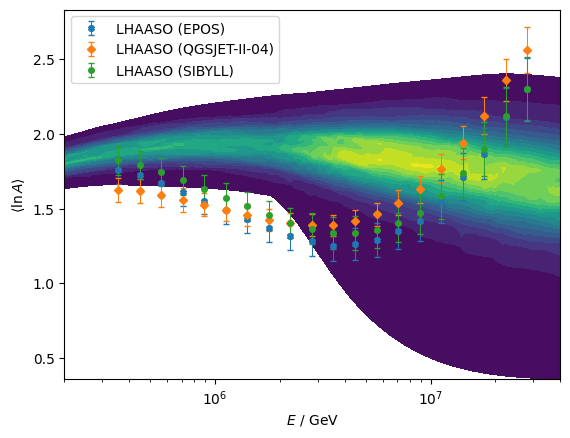

In [9]:
fig, ax = plt.subplots()

lnA_exps = (
    experiments.lhaaso_epos,
    experiments.lhaaso_sibyll,
    experiments.lhaaso_qgsjet,
)
for exp in lnA_exps:
    path = f"data/output/{exp.filename_prefix}_lnA_energy.txt"

    cols = (0, 1, 2, 3, 4, 5)
    E, value, err_sta_lo, err_sta_up, err_sys_lo, err_sys_up = np.loadtxt(
        path, usecols=cols, unpack=True
    )
    mask = np.ones_like(E, dtype=bool)
    GenericExperimentData(
        x=E[mask],
        y=value[mask],
        y_errhi=np.sqrt(err_sta_up[mask] ** 2 + err_sys_up[mask] ** 2),
        y_errlo=np.sqrt(err_sta_lo[mask] ** 2 + err_sys_lo[mask] ** 2),
        experiment=exp,
    ).plot(scale=0, ax=ax, add_label=True)


plot_posterior_contours(
    ax,
    scale=0,
    bounds=(2e5, 4e7),
    observable=lambda model, E: model.cr_model.compute_lnA(E),
    theta_sample=theta_sample,
    model_config=fc.model,
    tricontourf_kwargs={"levels": 15}
)
label_energy_flux(ax, scale=0)
ax.set_ylabel("$ \\langle \\ln A \\rangle $")
ax.set_xscale("log")
ax.legend()